In [1]:
!nvidia-smi

Thu Jan 23 18:25:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Download dataset

In [2]:
!pip install gdown torchinfo --quiet

In [3]:
import sys
sys.path.append('/content/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions')

In [4]:
import requests
from pathlib import Path

if Path("dataloader.py").is_file():
  print("File dataloader.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/dataloader.py")
  with open("dataloader.py", 'wb') as f:
    f.write(request.content)

In [5]:
if Path("evaluate.py").is_file():
  print("File evaluate.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/evaluate.py")
  with open("evaluate.py", 'wb') as f:
    f.write(request.content)

In [6]:
if Path("function.py").is_file():
  print("File function.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/function.py")
  with open("function.py", 'wb') as f:
    f.write(request.content)

In [7]:
if Path("train.py").is_file():
  print("File train.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/faster_rcnn/train.py")
  with open("train.py", 'wb') as f:
    f.write(request.content)

In [8]:
# Download model Zero-DCE
import requests
from pathlib import Path

if Path("8LE-color-loss2_best_model.pth").is_file():
    print("file đã tồn tại")
else:
    request = requests.get(url="https://github.com/bsun0802/Zero-DCE/raw/refs/heads/master/train-jobs/ckpt/8LE-color-loss2_best_model.pth")
    with open("8LE-color-loss2_best_model.pth", "wb") as f:
        f.write(request.content)

# 2. Load dataset from dataloader.py

In [9]:
from dataloader import TrafficVehicle
import cv2
import matplotlib.pyplot as plt
import torch
from function import collate_fn, loss_mAP_curve, precision_recall_curve, confidence_metric
from torch.utils.data import DataLoader, SubsetRandomSampler
import albumentations as A
from evaluate import evaluate
from train import train_step
import numpy as np
from torchvision import models
from torch import nn
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


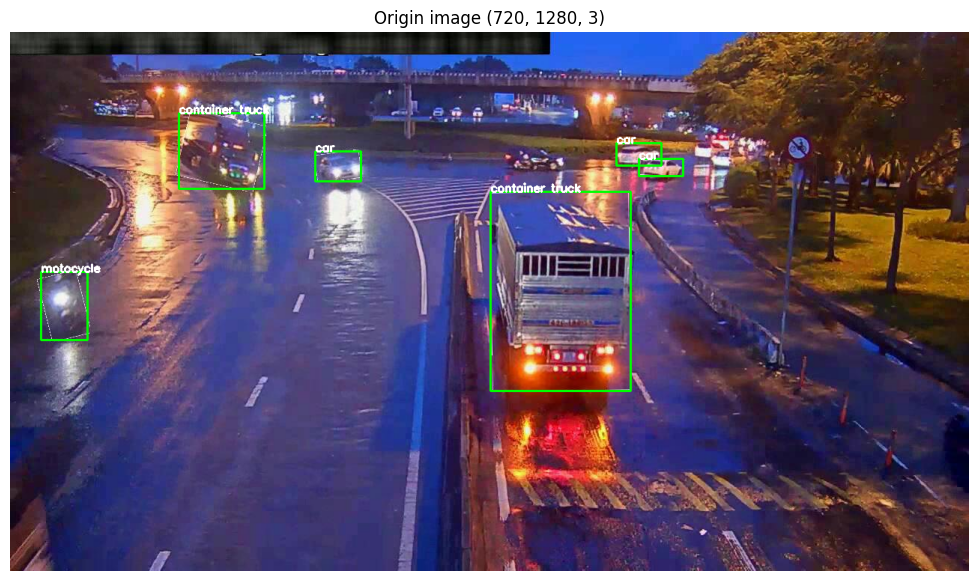

In [10]:
data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transform_box_type="corner")
origin_image = data[5520][0]

plt.figure(figsize=(15, 7))
labels, boxes = data[5520][1]['labels'], torch.Tensor.numpy(data[5520][1]['boxes'])
frame = origin_image.copy()

for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    annotated_image = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
    label_name = data.class_name[int(label)]
    annotated_image = cv2.putText(annotated_image, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                                color=(255, 255, 255), thickness=2)

plt.imshow(annotated_image)
plt.title(f"Origin image {origin_image.shape}")
plt.axis('off')
plt.show()

In [11]:
train_transform = A.Compose([
    A.Resize(300, 300),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(0.2, 0.2), p=0.5),
    A.HueSaturationValue(hue_shift_limit=(1, 1), p=0.5),
    A.Sharpen(p=0.5),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.3))

val_transform = A.Compose([
    A.Resize(300, 300),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transforms=train_transform, 
                            transform_box_type="corner")
val_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/val", transforms=val_transform, 
                          transform_box_type="corner")

Image after applying data augmentation



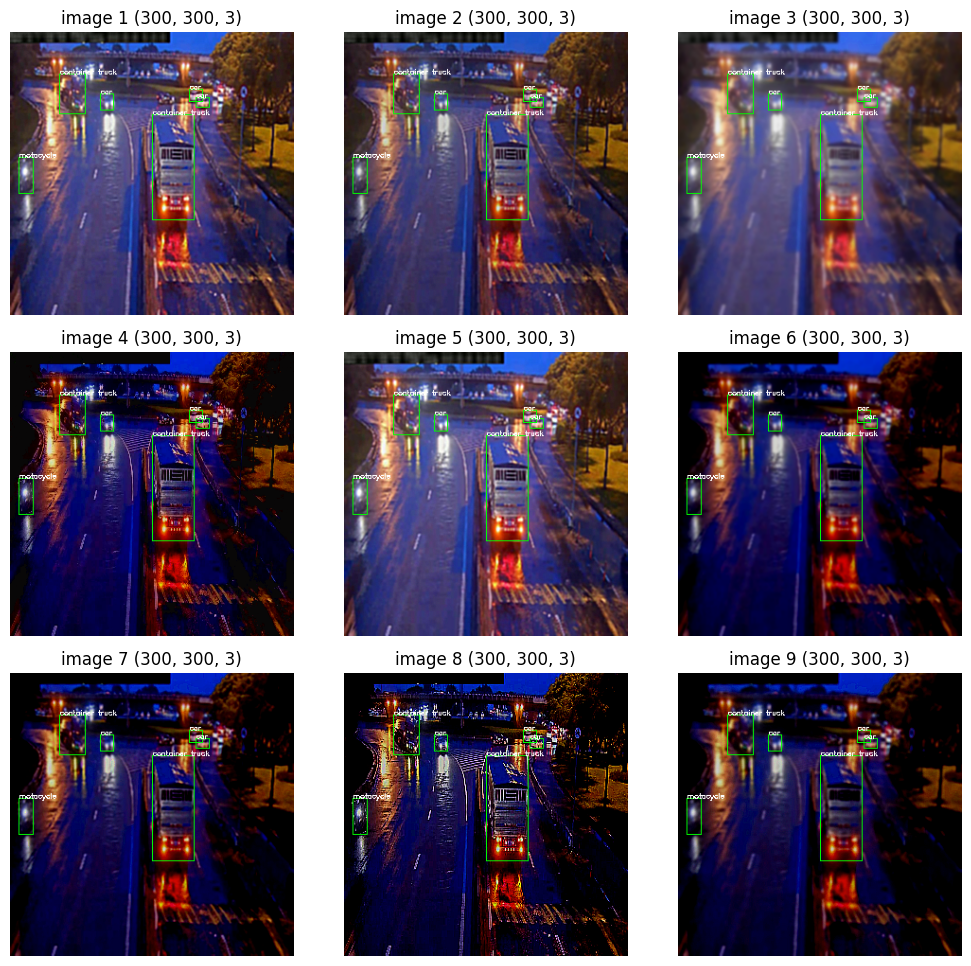

In [12]:
print("Image after applying data augmentation\n")
plt.figure(figsize=(10, 10))
for i in range(1, 10):
    img = torch.Tensor.numpy(train_data[5520][0].permute(1, 2, 0))

    height, width = origin_image.shape[:2]
    labels, boxes = train_data[5520][1]['labels'], torch.Tensor.numpy(train_data[5520][1]['boxes'])
    frame = img.copy()

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        annotated_img = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)
        label_name = train_data.class_name[int(label)]
        annotated_img = cv2.putText(annotated_img, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25,
                                    color=(255, 255, 255), thickness=1)

    plt.subplot(3, 3, i)
    plt.imshow(annotated_img)
    plt.title(f"image {i} {img.shape}")
    plt.tight_layout()
    plt.axis('off')

plt.show()

In [13]:
class_name = train_data.class_name
class_name

{1: 'motocycle', 2: 'car', 3: 'coach', 4: 'container truck'}

# 3. Prepare dataloader

In [14]:
print(f"Size of train_data: {len(train_data)}")
print(f"Size of val_data: {len(val_data)}")

Size of train_data: 9452
Size of val_data: 2067


In [15]:
torch.manual_seed(42)
# Load DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset=val_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)

# 4. Finetuning model

In [ ]:
import torch
import torchvision
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection import FasterRCNN

# Load pretrained 
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
mobilenet = torchvision.models.mobilenet_v3_large(weights=weights)

# Xác định returned layers
return_layers = {'3': '0', '6': '1',  '12': '2',  '15': '3'}

# Tạo backbone với FPN
backbone = BackboneWithFPN(
    mobilenet.features,
    return_layers=return_layers,
    in_channels_list=[24, 40, 112, 160],
    out_channels=256
)

# Khởi tạo FasterRCNN
num_classes = 5
model = FasterRCNN(backbone, 
                   num_classes=num_classes)

In [17]:
for param in model.backbone.parameters():
    param.requires_grad = False

<All keys matched successfully>

In [18]:
# Model Zero-DCE
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()
        self.iterations = 4
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=32*2, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=32*2, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=32*2, out_channels=24, kernel_size=(3, 3),
                              stride=1, padding=1, bias=True)
        
        self.relu = nn.ReLU(inplace=True)
  
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        # Skip connection
        x5 = self.relu(self.conv5(torch.cat([x3, x4], dim=1)))
        x6 = self.relu(self.conv6(torch.cat([x2, x5], dim=1)))
        x_r = F.tanh(self.conv7(torch.cat([x1, x6], dim=1)))
        
        
        # Chia thành 8 curve parameters cho mỗi kênh màu RGB 
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        x = x + r1*(torch.pow(x, 2) - x)
        x = x + r2*(torch.pow(x, 2) - x)
        x = x + r3*(torch.pow(x, 2) - x)
        enhance_image_1 = x + r4*(torch.pow(x, 2) - x)
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1, 2) - enhance_image_1)
        x = x + r6*(torch.pow(x, 2) - x)
        x = x + r7* (torch.pow(x, 2) - x)
        enhance_image = x + r8*(torch.pow(x, 2) - x)
        r = torch.cat([r1, r2, r3, r4, r5, r6, r7, r8], dim=1)

        return enhance_image_1, enhance_image, r

In [19]:
model_dce = ZeroDCE()
model_dce.load_state_dict(torch.load("/kaggle/working/8LE-color-loss2_best_model.pth", 
                                 weights_only=False,
                                 map_location='cuda:0')['model'])

<All keys matched successfully>

# 5. Training

In [20]:
# Thiết lập optimizer, device
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device use: {device}")
print(f"Input image shape: {train_data[0][0].shape}")
print(f"Input target: \n{train_data[0][1]}")

Device use: cuda
Input image shape: torch.Size([3, 300, 300])
Input target: 
{'labels': tensor([1, 4, 2, 2, 2, 2, 4, 4, 1, 1, 1, 1]), 'boxes': tensor([[ 44.2969,  71.2500,  50.3906,  88.7500],
        [ 76.4062,  53.7500, 104.0625, 123.3333],
        [239.0625, 249.5833, 300.0000, 300.0000],
        [152.5781,  89.5833, 164.0625, 108.7500],
        [155.8594,  78.7500, 168.2812,  97.0833],
        [164.7656,  70.4167, 179.7656,  89.5833],
        [176.2500,  79.5833, 189.8438, 113.7500],
        [188.2031,  52.9167, 211.8750,  77.5000],
        [126.0938,  61.2500, 134.2969,  72.9167],
        [152.3438,  60.4167, 160.3125,  72.9167],
        [109.6875,  62.5000, 116.0156,  72.5000],
        [114.3750,  60.0000, 119.7656,  70.8333]])}


In [21]:
# Đường dẫn lưu model
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [22]:
print(f"-----------------------Training-----------------------\n")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results = {
    "epoch_value": [],
    "loss": [],
    "loss_classifier": [],
    "loss_box_reg": [],
    "loss_objectness": [],
    "loss_rpn_box_reg": [],
    "mAP50": []
}
epochs = 20

patience = 3  # Số epoch không cải thiện mAP
best_mAP = 0  # Lưu mAP tốt nhất
patience_counter = 0  # Đếm số epoch mà mAP không cải thiện

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loss, loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg = train_step(train_dataloader=train_dataloader,
                                                                                         model=model,
                                                                                         optimizer=optimizer,
                                                                                         device=device,
                                                                                         model_dce=model_dce)

    lr_scheduler.step()
    
    mAP, AP_per_class = evaluate(val_dataloader=val_dataloader,
                                 model=model,
                                 num_class=num_classes-1,
                                 iou_threshold=0.5,
                                 device=device,
                                 model_dce=model_dce)

    results["epoch_value"].append(epoch + 1)
    results["loss"].append(loss.item() if isinstance(loss, torch.Tensor) else loss)
    results["loss_classifier"].append(loss_classifier.item() if isinstance(loss_classifier, torch.Tensor) else loss_classifier)
    results["loss_box_reg"].append(loss_box_reg.item() if isinstance(loss_box_reg, torch.Tensor) else loss_box_reg)
    results["loss_objectness"].append(loss_objectness.item() if isinstance(loss_objectness, torch.Tensor) else loss_objectness)
    results["loss_rpn_box_reg"].append(loss_rpn_box_reg.item() if isinstance(loss_rpn_box_reg, torch.Tensor) else loss_rpn_box_reg)

    print(f"Loss: {loss:.4f}, Loss classifier: {loss_classifier:.4f}, Loss box: {loss_box_reg:.4f}, Loss objectness: {loss_objectness:.4f}, Loss rpn_box: {loss_rpn_box_reg:.4f}")

    for class_id in range(1, num_classes):
        class_ap = AP_per_class.get(class_id, 0)
        print(f"Average Precision of {train_data.class_name[class_id]}: {class_ap:.4f}")

    results["mAP50"].append(mAP)

    print(f"Mean Average Precision (mAP@IoU=0.5): {mAP:.4f}")

    # Early stopping check
    if mAP > best_mAP:
        best_mAP = mAP
        patience_counter = 0  # Reset counter nếu mAP không cải thiện
        # Save model
        torch.save(obj=model.state_dict(),
                   f=MODEL_SAVE_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in mAP.")
            break  # Dừng huấn luyện khi không cải thiện mAP trong nhiều epoch

-----------------------Training-----------------------

Epoch 1/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2297, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3336, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1426, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0754, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.6872, Loss classifier: 0.2195, Loss box: 0.3578, Loss objectness: 0.0561, Loss rpn_box: 0.0539
Average Precision of motocycle: 0.6911
Average Precision of car: 0.7975
Average Precision of coach: 0.8168
Average Precision of container truck: 0.7871
Mean Average Precision (mAP@IoU=0.5): 0.7731
Epoch 2/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1552, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3071, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0248, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0483, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.5982, Loss classifier: 0.1909, Loss box: 0.3354, Loss objectness: 0.0289, Loss rpn_box: 0.0430
Average Precision of motocycle: 0.7113
Average Precision of car: 0.8189
Average Precision of coach: 0.8741
Average Precision of container truck: 0.8254
Mean Average Precision (mAP@IoU=0.5): 0.8074
Epoch 3/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2201, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3689, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0350, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0494, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.5496, Loss classifier: 0.1748, Loss box: 0.3152, Loss objectness: 0.0219, Loss rpn_box: 0.0377
Average Precision of motocycle: 0.7148
Average Precision of car: 0.8175
Average Precision of coach: 0.8836
Average Precision of container truck: 0.8398
Mean Average Precision (mAP@IoU=0.5): 0.8139
Epoch 4/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2279, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4238, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0246, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0581, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.5070, Loss classifier: 0.1614, Loss box: 0.2942, Loss objectness: 0.0184, Loss rpn_box: 0.0331
Average Precision of motocycle: 0.7229
Average Precision of car: 0.8171
Average Precision of coach: 0.8938
Average Precision of container truck: 0.8486
Mean Average Precision (mAP@IoU=0.5): 0.8206
Epoch 5/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1412, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2481, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0128, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0206, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4993, Loss classifier: 0.1587, Loss box: 0.2906, Loss objectness: 0.0175, Loss rpn_box: 0.0325
Average Precision of motocycle: 0.7210
Average Precision of car: 0.8209
Average Precision of coach: 0.8915
Average Precision of container truck: 0.8530
Mean Average Precision (mAP@IoU=0.5): 0.8216
Epoch 6/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1127, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2361, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0128, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4928, Loss classifier: 0.1561, Loss box: 0.2877, Loss objectness: 0.0170, Loss rpn_box: 0.0321
Average Precision of motocycle: 0.7249
Average Precision of car: 0.8188
Average Precision of coach: 0.8954
Average Precision of container truck: 0.8495
Mean Average Precision (mAP@IoU=0.5): 0.8221
Epoch 7/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.2499, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3578, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0371, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0541, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4890, Loss classifier: 0.1545, Loss box: 0.2860, Loss objectness: 0.0168, Loss rpn_box: 0.0316
Average Precision of motocycle: 0.7233
Average Precision of car: 0.8166
Average Precision of coach: 0.8933
Average Precision of container truck: 0.8512
Mean Average Precision (mAP@IoU=0.5): 0.8211
Epoch 8/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1298, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3240, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0225, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0411, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4881, Loss classifier: 0.1545, Loss box: 0.2853, Loss objectness: 0.0167, Loss rpn_box: 0.0316
Average Precision of motocycle: 0.7240
Average Precision of car: 0.8186
Average Precision of coach: 0.8968
Average Precision of container truck: 0.8522
Mean Average Precision (mAP@IoU=0.5): 0.8229
Epoch 9/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1473, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2770, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0097, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4880, Loss classifier: 0.1546, Loss box: 0.2854, Loss objectness: 0.0166, Loss rpn_box: 0.0315
Average Precision of motocycle: 0.7232
Average Precision of car: 0.8176
Average Precision of coach: 0.8942
Average Precision of container truck: 0.8525
Mean Average Precision (mAP@IoU=0.5): 0.8219
Epoch 10/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1597, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2274, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0143, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0245, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4863, Loss classifier: 0.1536, Loss box: 0.2847, Loss objectness: 0.0165, Loss rpn_box: 0.0315
Average Precision of motocycle: 0.7234
Average Precision of car: 0.8183
Average Precision of coach: 0.8942
Average Precision of container truck: 0.8529
Mean Average Precision (mAP@IoU=0.5): 0.8222
Epoch 11/20


  0%|          | 0/1182 [00:00<?, ?it/s]

batch 1: 
{'loss_classifier': tensor(0.1830, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3217, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0363, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0340, device='cuda:0', grad_fn=<DivBackward0>)}


  0%|          | 0/259 [00:00<?, ?it/s]

Loss: 0.4866, Loss classifier: 0.1538, Loss box: 0.2844, Loss objectness: 0.0170, Loss rpn_box: 0.0315
Average Precision of motocycle: 0.7242
Average Precision of car: 0.8171
Average Precision of coach: 0.8951
Average Precision of container truck: 0.8513
Mean Average Precision (mAP@IoU=0.5): 0.8219
Early stopping at epoch 11 due to no improvement in mAP.


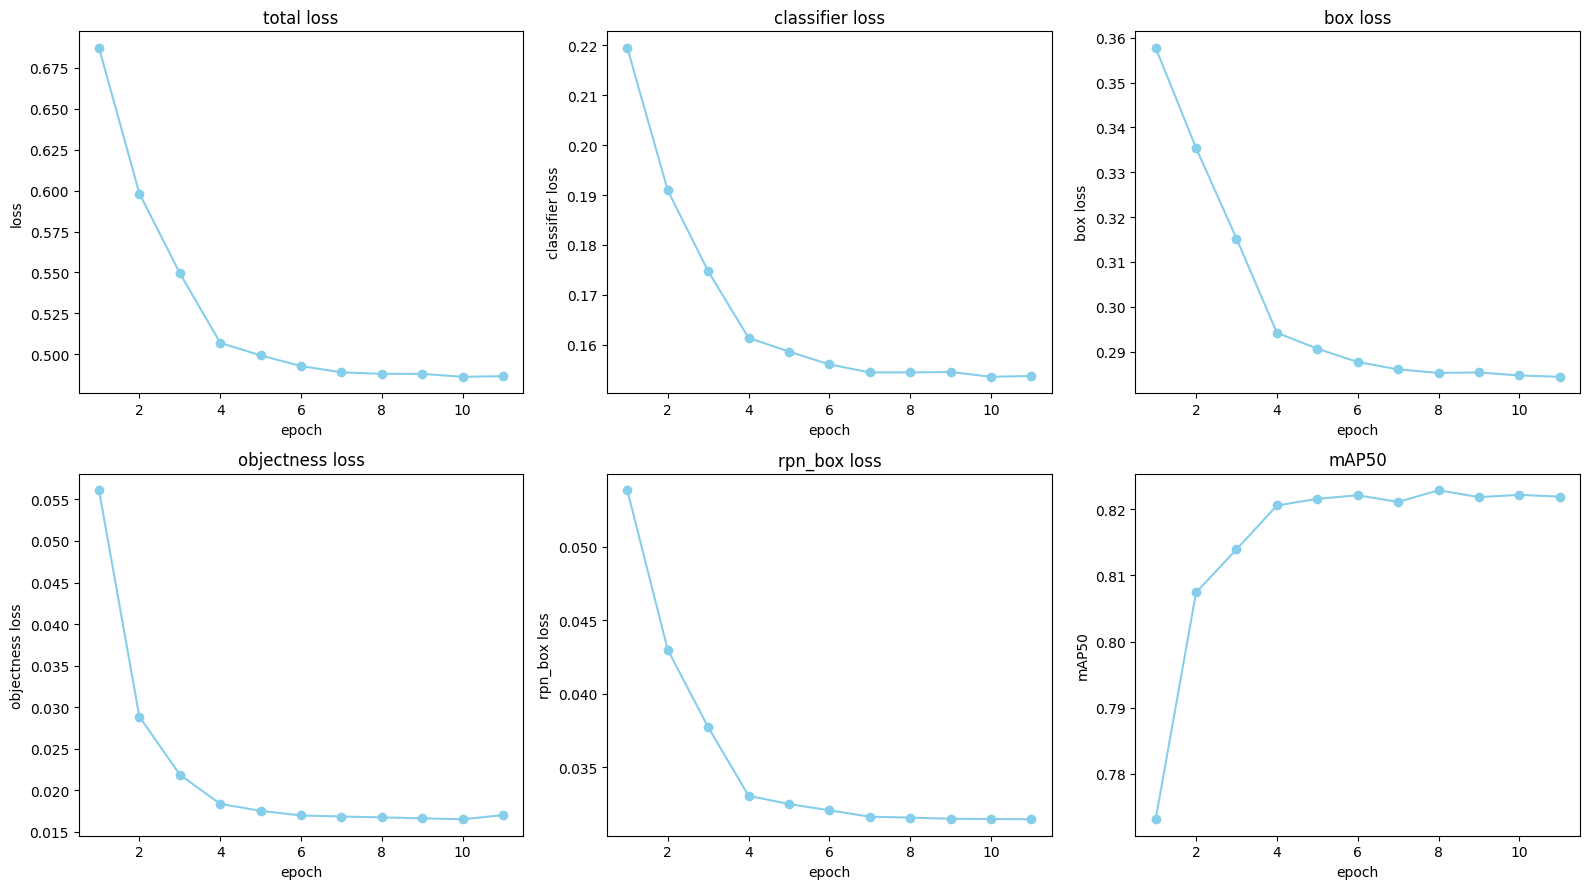

In [23]:
# Visualize loss và mAP
loss_mAP_curve(results)

# 6. Evaluation

In [24]:
def iou(boxes1, boxes2):
    """
    Tính IoU giữa tất cả các cặp boxes từ boxes1 và boxes2
    Args:
        boxes1 (torch.Tensor): shape (N, 4) - N boxes với format (x1, y1, x2, y2)
        boxes2 (torch.Tensor): shape (M, 4) - M boxes với format (x1, y1, x2, y2)
    Returns:
        torch.Tensor: shape (N, M) - ma trận IoU
    """
    # Tính area của boxes1
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # shape: (N,)
    
    # Tính area của boxes2
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # shape: (M,)
    
    # Mở rộng kích thước để broadcast
    # boxes1: (N, 1, 4), boxes2: (1, M, 4)
    boxes1 = boxes1[:, None, :]  # Thêm chiều mới ở giữa
    boxes2 = boxes2[None, :, :]  # Thêm chiều mới ở đầu
    
    # Tính tọa độ của phần giao nhau
    left_top = torch.maximum(boxes1[..., :2], boxes2[..., :2])  # shape: (N, M, 2)
    right_bottom = torch.minimum(boxes1[..., 2:], boxes2[..., 2:])  # shape: (N, M, 2)
    
    # Tính width và height của phần giao nhau
    wh = (right_bottom - left_top).clamp(min=0)  # shape: (N, M, 2)
    inter = wh[..., 0] * wh[..., 1]  # shape: (N, M)
    
    # Tính union
    union = area1[:, None] + area2[None, :] - inter
    
    # Tính IoU
    iou = inter / union.clamp(min=1e-6)
    
    return iou

In [25]:
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
import torch

def validate(val_dataloader, model, num_class, iou_threshold, device):
    model = model.to(device)
    model.eval()
    
    # Khởi tạo các biến để tính precision và recall
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    # Khởi tạo metric MAP
    metric = MeanAveragePrecision(
        iou_type="bbox",
        iou_thresholds=[iou_threshold],
        box_format="xyxy",
        class_metrics=True
    ).to(device)
    
    with torch.inference_mode():
        for batch, (images, targets) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            images = [image.to(device) for image in images]
            enhanced_images = []
            for image in images:
                _, enhance_image, _ = model_dce(image.unsqueeze(0))
                enhanced_images.append(enhance_image.squeeze())
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(enhanced_images)
            
            preds = [{
                "boxes": output["boxes"],
                "scores": output["scores"],
                "labels": output["labels"],
            } for output in outputs]
            
            gt = [{
                "boxes": target["boxes"],
                "labels": target["labels"],
            } for target in targets]
            
            metric.update(preds, gt)
            
            for pred, target in zip(preds, gt):
                pred_boxes = pred["boxes"]
                pred_scores = pred["scores"]
                pred_labels = pred["labels"]
                gt_boxes = target["boxes"]
                gt_labels = target["labels"]
                
                ious = iou(pred_boxes, gt_boxes)
                
                # Chuyển IoU thành mask bool và sau đó thành float để có thể dùng argmax
                matches = (ious > iou_threshold).float()
                
                for pred_idx in range(len(pred_boxes)):
                    if pred_scores[pred_idx] > 0.5:
                        if matches[pred_idx].any():
                            # Tìm gt_idx có IoU cao nhất với pred_idx
                            gt_idx = matches[pred_idx].argmax()
                            if pred_labels[pred_idx] == gt_labels[gt_idx]:
                                true_positives += 1
                            else:
                                false_positives += 1
                        else:
                            false_positives += 1
                
                # Đếm false negatives
                matched_gt = matches.sum(dim=0) > 0  # Chuyển về bool
                false_negatives += (~matched_gt).sum().item()
    
    # Tính toán kết quả MAP
    result = metric.compute()
    mAP50 = result["map_50"].item()
    mAP50_95 = result["map"].item()
    
    # Tính precision và recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # Tính F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return mAP50, mAP50_95, f1_score

In [26]:
mAP50, mAP50_95, f1_score = validate(val_dataloader=val_dataloader,
                                     model=model,
                                     num_class=num_classes-1,
                                     iou_threshold=0.5,
                                     device=device)
print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")
print(f"F1-score: {f1_score:.4f}")

100%|██████████| 259/259 [01:44<00:00,  2.48it/s]


mAP@50: 0.8219
mAP@50-95: 0.8219
F1-score: 0.7739
